# Risk free curve test
<a id="0"></a> <br>


### Executive summary

The risk free curve is one of the principal inputs into an economic scenario generator. This notebook recalculates the risk free curve using the parameters that are claimed to be used. The European Insurance and Occupational Pensions Authority (EIOPA)  publishes their own prediction of the future risk free rates. To do this they use the Smith & Wilson algorithm.

### Goal

The goal is to replicate the EIOPA curve provided, using the methodology that EIOPA claims it is using. If the test is passed, the user can be more confident, that EIOPA uses the described methodology and that it was implemented correctly. 


# Table of contents
 1. [Note on Smith & Wilson algorithm](#1)
 2. [Data requirements](#2)
 3. [Success criteria](#3)
 4. [Step 1: Insert provided data](#4)
 5. [Step 2: Smith & Wilson calculation functions](#5)
 6. [Step 3: Generation of the final output curve](#6)
 7. [Step 4: Comparson test](#7)

<a id="1"></a> <br>
## Note on Smith & Wilson algorithm

To replicate the calculations, this example uses a slight modification to the original implementation that is avalible on our GitHub. The original implementation can be found in different languages on the OSM's GitHub repository:
-  [Python](https://github.com/qnity/insurance_python/tree/main/smith%26wilson)
-  [Matlab](https://github.com/qnity/insurance_matlab/tree/main/smith%26wilson)
-  [JavaScript](https://github.com/qnity/insurance_javascript/tree/main/smith-wilson)

<a id="2"></a> <br>
## Data requirements

In this example, we look at the EIOPA risk free rate publication for August 2022. The publication can be found on the [EIOPA RFR website](https://www.eiopa.europa.eu/tools-and-data/risk-free-interest-rate-term-structures_en).

The observed maturities `M_Obs` and the calibrated vector `Qb` can be found in the Excel sheet *EIOPA_RFR_20220831_Qb_SW.xlsx.

For this example, the curve without the volatility adjustment (VA) is used. It can be found in the sheet *SW_Qb_no_VA*. This example is focused on the EUR curve, but this example can be easily modified for any other curve.

The target maturities (`T_Obs`), the additional parameters (`UFR` and `alpha`) and the given curve can be found in the Excel *EIOPA_RFR_20220831_Term_Structures.xlsx*, sheet *RFR_spot_no_VA*.

[Back to the top](#0)
<a id="3"></a> <br>
## Success criteria

In this example, the following success criteria is proposed:
-  Maximum difference between the given curve and the recalculated curve is less than 100 bps.
-  Average difference between the curves is less than 10 bps.

In [12]:
test_statistics_max_diff_in_bps = 0.1
test_statistics_average_diff_in_bps = 0.05

This implementation uses three well established Python packages widely used in the financial industry. Pandas (https://pandas.pydata.org/docs/), Numpy (https://numpy.org/doc/), and Matplotlib (https://matplotlib.org/stable/index.html)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

[Back to the top](#0)
<a id="4"></a> <br>
### Step 1: Input provided data

Insertion of data provided by EIOPA.

In [14]:
M_Obs = np.transpose(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]))
ufr = 0.0345 # Ultimate froward rate ufr represents the rate to which the rate curve will converge as time increases.
alpha = 0.123101; # Convergence speed parameter alpha controls the speed at which the curve converges towards the ufr from the last liquid point.
M_Target = np.transpose(np.arange(1,150)) # For which maturities do we want the SW algorithm to calculate the rates. In this case, for every year up to 65.

Qb = np.transpose(np.array([16.6492808327834,-15.5532139436678,  6.35667251451134, -1.23854722782483,  0.365103848953126,-1.0571571437455, 1.33917386115124, -0.278129268962339,-2.90540200100003, 10.0852060296744, -13.5164497129641, 7.48340006599309, -0.030860450530635,-0.02983127165842, -2.20860220321924,  0.022505350081095, 0.021754809164905, 0.021029298371102, 0.020327982959016, 0.888352798117858]))

[Back to the top](#0)
<a id="5"></a> <br>
### Step 2: Smith & Wilson calculation functions

Two functions are taken from our GithHub repository and modified to accept the product of `Q*b` instead of the calibration vector `b`.

In [15]:
def SWExtrapolate(M_Target, M_Obs, Qb, ufr, alpha):
# SWEXTRAPOLATE Interpolate or/and extrapolate rates for targeted maturities using a Smith-Wilson algorithm.
# r = SWExtrapolate(T_Target,T_Obs, b, ufr, alpha) calculates the rates for maturities specified in M_Target using the calibration vector b.
#
# Arguments: 
#    M_Target = k x 1 ndarray. Each element represents a bond maturity of interest. Ex. M_Target = [[1], [2], [3], [5]]
#    M_Obs =    n x 1 ndarray. Observed bond maturities used for calibrating the calibration vector b. Ex. M_Obs = [[1], [3]]
#    Qb =       n x 1 ndarray calibration vector calculated on observed bonds.
#    ufr =      1 x 1 floating number, representing the ultimate forward rate.
#       Ex. ufr = 0.042
#    alpha =    1 x 1 floating number representing the convergence speed parameter alpha. Ex. alpha = 0.05
#    rates
#
# Returns:
#    k x 1 ndarray. Represents the targeted rates for a zero-coupon bond. Each rate belongs to a targeted zero-coupon bond with a maturity from T_Target. Ex. r = [0.0024; 0.0029; 0.0034; 0.0039]
#
# For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf

    def SWHeart(u, v, alpha):
    # SWHEART Calculate the heart of the Wilson function.
    # H = SWHeart(u, v, alpha) calculates the matrix H (Heart of the Wilson
    # function) for maturities specified by vectors u and v. The formula is
    # taken from the EIOPA technical specifications paragraph 132.
    #
    # Arguments:  
    #    u =     n_1 x 1 vector of maturities. Ex. u = [1; 3]
    #    v =     n_2 x 1 vector of maturities. Ex. v = [1; 2; 3; 5]
    #    alpha = 1 x 1 floating number representing the convergence speed parameter alpha. Ex. alpha = 0.05
    #
    # Returns:
    #    n_1 x n_2 matrix representing the Heart of the Wilson function for selected maturities and parameter alpha. H is calculated as in the paragraph 132 of the EIOPA documentation. 
    #
    # For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf

        u_Mat = np.tile(u, [v.size, 1]).transpose()
        v_Mat = np.tile(v, [u.size, 1])
        return 0.5 * (alpha * (u_Mat + v_Mat) + np.exp(-alpha * (u_Mat + v_Mat)) - alpha * np.absolute(u_Mat-v_Mat) - np.exp(-alpha * np.absolute(u_Mat-v_Mat))); # Heart of the Wilson function from paragraph 132

    H = SWHeart(M_Target, M_Obs, alpha) # Heart of the Wilson function from paragraph 132
    p = np.exp(-np.log(1+ufr)* M_Target) + np.diag(np.exp(-np.log(1+ufr) * M_Target)) @ H @ Qb # Discount pricing function for targeted maturities from paragraph 147
    return p ** (-1/ M_Target) -1 # Convert obtained prices to rates and return prices

[Back to the top](#0)
<a id="6"></a> <br>
### Step 3: Generation of the final output curve

The obseerved maturities, target maturities and the model parameters provided by EIOPA are used to generate the target curve.

In [16]:
r_Target = SWExtrapolate(M_Target,M_Obs, Qb, ufr, alpha)
r_Target = pd.DataFrame(r_Target,columns=['Recalculated rates'])

r_Target.head()

,Recalculated rates
0,0.017450
1,0.020845
2,0.021150
3,0.021422
4,0.021729


[Back to the top](#0)
<a id="7"></a> <br>
### Step 4: Comparson test

Comparison of the output curve with the final curve provided by EIOPA. The test is passed if the success criteria is reached. 

The provided curve is availabe in the Excel sheet: *EIOPA_RFR_20220831_Term_Structures* in the sheet *RFR_spot_no_VA*    

In [17]:
EUR_curve = np.transpose(np.array([0.01745,0.02085,0.02115,0.02142,0.02173000000,0.02201000000,0.02227000000,0.02261000000,0.02295000000,0.02333000000,0.02382000000,0.02390000000,0.02400000000,0.02411000000,0.02408000000,0.02384000000,0.02347000000,0.02308000000,0.02274000000,0.02249000000,0.02235000000,0.02231000000,0.02235000000,0.02244000000,0.02258000000,0.02274000000,0.02293000000,0.02313000000,0.02334000000,0.02356000000,0.02378000000,0.02401000000,0.02423000000,0.02445000000,0.02467000000,0.02488000000,0.02509000000,0.02529000000,0.02549000000,0.02568000000,0.02587000000,0.02605000000,0.02622000000,0.02639000000,0.02656000000,0.02672000000,0.02687000000,0.02702000000,0.02716000000,0.02730000000,0.02743000000,0.02756000000,0.02769000000,0.02781000000,0.02793000000,0.02804000000,0.02815000000,0.02826000000,0.02836000000,0.02846000000,0.02856000000,0.02865000000,0.02874000000,0.02883000000,0.02892000000,0.02900000000,0.02908000000,0.02916000000,0.02924000000,0.02931000000,0.02939000000,0.02946000000,0.02953000000,0.02959000000,0.02966000000,0.02972000000,0.02978000000,0.02984000000,0.02990000000,0.02996000000,0.03001000000,0.03007000000,0.03012000000,0.03017000000,0.03022000000,0.03027000000,0.03032000000,0.03037000000,0.03042000000,0.03046000000,0.03051000000,0.03055000000,0.03059000000,0.03063000000,0.03067000000,0.03071000000,0.03075000000,0.03079000000,0.03083000000,0.03086000000,0.03090000000,0.03094000000,0.03097000000,0.03100000000,0.03104000000,0.03107000000,0.03110000000,0.03113000000,0.03116000000,0.03119000000,0.03122000000,0.03125000000,0.03128000000,0.03131000000,0.03134000000,0.03137000000,0.03139000000,0.03142000000,0.03144000000,0.03147000000,0.03149000000,0.03152000000,0.03154000000,0.03157000000,0.03159000000,0.03161000000,0.03164000000,0.03166000000,0.03168000000,0.03170000000,0.03172000000,0.03174000000,0.03177000000,0.03179000000,0.03181000000,0.03183000000,0.03185000000,0.03186000000,0.03188000000,0.03190000000,0.03192000000,0.03194000000,0.03196000000,0.03197000000,0.03199000000,0.03201000000,0.03203000000,0.03204000000,0.03206000000])) 
EUR_curve = pd.DataFrame(EUR_curve,columns=['Given rates'])
EUR_curve.head()

,Given rates
0,0.01745
1,0.02085
2,0.02115
3,0.02142
4,0.02173


This implementation looks at two kinds of test statistics. The average difference and the maximum deviation. They are defined as:

<font size=4>
$$S_{AVERAGE} = \frac{1}{T} \sum_{t = 0}^N \left|r_{EIOPA}(t) - r_{EST}(t) \right|$$
</font> <br>

<font size=4>
$$ S_{MAX} = \max_t \left| r_{EIOPA}(t) - r_{EST}(t) \right| $$

</font> <br>

The average difference test is sucessfull if:
<font size=4>
$$S_{AVERAGE} < 0.000005$$   
</font> <br>


The maximum difference test is sucessfull if:
<font size=4>
$$ S_{MAX} <  0.00001 $$
</font> <br>



In [18]:
test_statistics_bdp = pd.DataFrame(abs(r_Target.values-EUR_curve.values)*10000, columns=["Abs diff in bps"])
test_statistics_bdp.head()

,Abs diff in bps
0,2.423756e-10
1,4.921938e-02
2,3.519053e-03
3,1.871457e-02
4,7.976257e-03


<IPython.core.display.Javascript object>


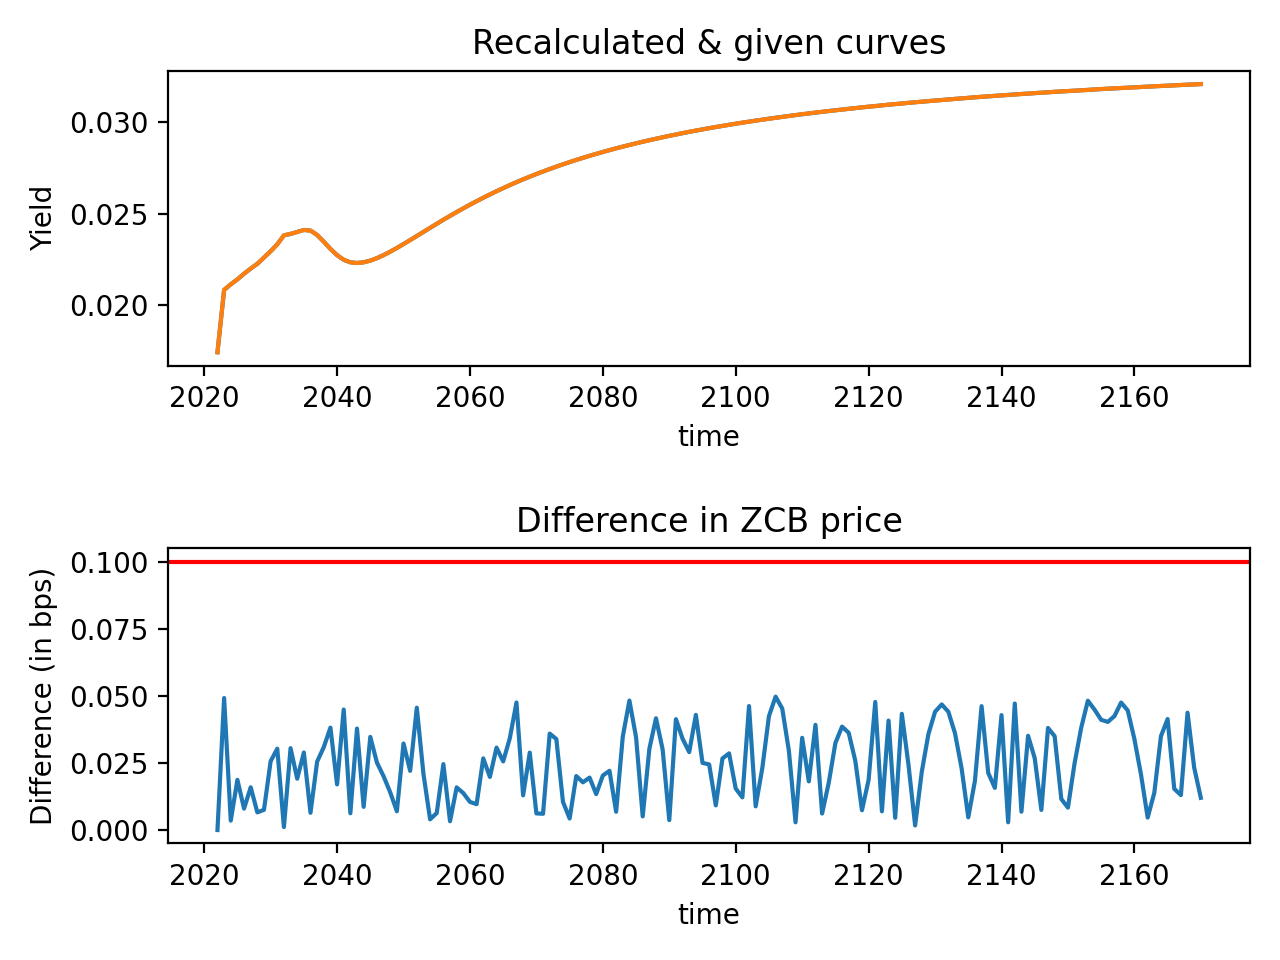

In [19]:
x_data_label = range(2022,2022+r_Target.shape[0],1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(x_data_label, r_Target.values, color='tab:blue')
ax1.plot(x_data_label, EUR_curve.values, color='tab:orange')

ax1.set_xlabel("time")
ax1.set_ylabel("Yield")
ax1.set_title('Recalculated & given curves')

ax2.plot(x_data_label, test_statistics_bdp)
ax2.axhline(y = test_statistics_max_diff_in_bps, color = 'r', linestyle = '-')

ax2.set_xlabel("time")
ax2.set_ylabel("Difference (in bps)")
ax2.set_title('Difference in ZCB price')
fig.tight_layout(h_pad=2)
plt.show()

In [20]:
if test_statistics_max_diff_in_bps > np.max(test_statistics_bdp.values):
    print("Passed the max difference test")
else:
    print("Failed the max difference test")

Passed the max difference test


In [21]:
if test_statistics_average_diff_in_bps>np.mean(test_statistics_bdp.values):
    print("Passed the average difference test")
else:
    print("Failed the average difference test")

Passed the average difference test
